In [12]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [13]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

import pickle

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [14]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


fashion


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


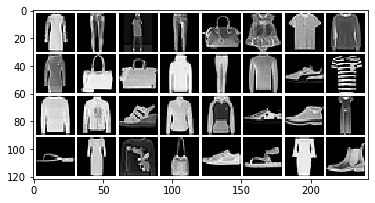

torch.Size([32, 1, 28, 28])


In [15]:
### LOAD DATA ###
dataset = 'fashion'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [16]:
def calc_meas(x):
    m = A.shape[1]
    n = x.shape[-1] * x.shape[-2]
    assert(m <= n)
    N = x.shape[0]
    C = x.shape[1]
    compressed = (x.view(N, C, -1) @ A).view(N, C, m)
    compressed = torch.abs(compressed)

    compr_pad = nn.functional.pad(compressed, (0, n - m), mode='constant', value=0).reshape(x.shape)
    
    return compressed, compr_pad

# Function to compute test images

def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        _, meas_pad = calc_meas(data)
        ouput = model(meas_pad)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [17]:
# Define loss

def gen_loss(gen_output, x):
    return  torch.mean(torch.abs(gen_output - x))

In [18]:
m = 25 # 10, 25, 50, 100, 200, 300, 500, 784

import pickle

#A = (torch.randn(imsize[1] * imsize[2], m) / m).to(device)
#pickle.dump(A, open("../cache/A/A{}.p".format(m), "wb"))

A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)

print(A.shape)

torch.Size([784, 25])


In [19]:
### Create new models ###

gen = models.FCNet(imsize=imsize, h=2048)

Version 0.4


In [20]:
# Set training parameters

opt = optim.Adam(gen.parameters(), lr=1e-3)

In [21]:
# Initial loss

gen = gen.to(device)
sample = sample.to(device)
sample_magnitudes = sample_magnitudes.to(device)

gen_out = gen(sample_magnitudes)

loss = gen_loss(gen_out, sample)

print("Generator loss:", loss.item())

Generator loss: 0.38576480746269226


In [22]:
# Train function (short)
def train_model(gen, opt, device, loader_train, epochs=1):
    gen = gen.to(device=device)
    
    history = []
    
    for e in range(epochs):
        for t, x in enumerate(loader_train):
            gen.train()
            
            x = x.to(device=device)
            _, meas_pad = calc_meas(x)
            
            loss = gen_loss(gen(meas_pad), x)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            history.append(loss.item())

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history[-1]))  

    return history

In [ ]:
### TRAIN MODEL ###

num_epochs = 1

train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()

torch.save(gen_weights, "../cache/e2e/Ameas{1}FCNet2048Fashion_{0:04d}.sd".format(num_epochs, m))

In [ ]:
### TRAIN MODEL - BIG LOOP ###

num_epochs = 100

for m in [10, 25, 50, 100, 200, 300, 500, 784]:

    A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)

    gen = models.FCNet(imsize=imsize, h=2048)
    
    opt = optim.Adam(gen.parameters(), lr=1e-3)

    train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

    gen_weights = gen.state_dict().copy()

    torch.save(gen_weights, "../cache/e2e/Ameas{1}FCNet2048Fashion_{0:04d}.sd".format(num_epochs, m))

Version 0.4
epoch:  1 	 step:0 	 loss: 0.4007
epoch:  1 	 step:100 	 loss: 0.1383
epoch:  1 	 step:200 	 loss: 0.1341
epoch:  1 	 step:300 	 loss: 0.1227
epoch:  1 	 step:400 	 loss: 0.1146
epoch:  1 	 step:500 	 loss: 0.1376
epoch:  1 	 step:600 	 loss: 0.1763
epoch:  1 	 step:700 	 loss: 0.139
epoch:  1 	 step:800 	 loss: 0.1116
epoch:  1 	 step:900 	 loss: 0.1298
epoch:  1 	 step:1000 	 loss: 0.1179
epoch:  1 	 step:1100 	 loss: 0.1089
epoch:  1 	 step:1200 	 loss: 0.1216
epoch:  1 	 step:1300 	 loss: 0.135
epoch:  1 	 step:1400 	 loss: 0.1439
epoch:  1 	 step:1500 	 loss: 0.113
epoch:  1 	 step:1600 	 loss: 0.1222
epoch:  1 	 step:1700 	 loss: 0.1416
epoch:  1 	 step:1800 	 loss: 0.1162
epoch:  2 	 step:0 	 loss: 0.1218
epoch:  2 	 step:100 	 loss: 0.1219
epoch:  2 	 step:200 	 loss: 0.1074
epoch:  2 	 step:300 	 loss: 0.1108
epoch:  2 	 step:400 	 loss: 0.1498
epoch:  2 	 step:500 	 loss: 0.1263
epoch:  2 	 step:600 	 loss: 0.1275
epoch:  2 	 step:700 	 loss: 0.1091
epoch:  2 	 st

epoch: 12 	 step:1600 	 loss: 0.09385
epoch: 12 	 step:1700 	 loss: 0.1018
epoch: 12 	 step:1800 	 loss: 0.1055
epoch: 13 	 step:0 	 loss: 0.1006
epoch: 13 	 step:100 	 loss: 0.09793
epoch: 13 	 step:200 	 loss: 0.1053
epoch: 13 	 step:300 	 loss: 0.1066
epoch: 13 	 step:400 	 loss: 0.1095
epoch: 13 	 step:500 	 loss: 0.1047
epoch: 13 	 step:600 	 loss: 0.1288
epoch: 13 	 step:700 	 loss: 0.1192
epoch: 13 	 step:800 	 loss: 0.1038
epoch: 13 	 step:900 	 loss: 0.1178
epoch: 13 	 step:1000 	 loss: 0.101
epoch: 13 	 step:1100 	 loss: 0.0965
epoch: 13 	 step:1200 	 loss: 0.1262
epoch: 13 	 step:1300 	 loss: 0.1138
epoch: 13 	 step:1400 	 loss: 0.09737
epoch: 13 	 step:1500 	 loss: 0.09285
epoch: 13 	 step:1600 	 loss: 0.09598
epoch: 13 	 step:1700 	 loss: 0.1
epoch: 13 	 step:1800 	 loss: 0.09665
epoch: 14 	 step:0 	 loss: 0.09957
epoch: 14 	 step:100 	 loss: 0.1041
epoch: 14 	 step:200 	 loss: 0.1172
epoch: 14 	 step:300 	 loss: 0.1028
epoch: 14 	 step:400 	 loss: 0.09677
epoch: 14 	 step

In [67]:
### LOAD MODEL ####

m = 784
num_epochs = 100

A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)
print(A.shape)

gen = models.FCNet(imsize=imsize, h=2048)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/e2e/Ameas{1}FCNet2048Fashion_{0:04d}.sd".format(num_epochs, m), map_location={'cuda:1': device.__str__()}));
gen.eval();

torch.Size([784, 784])
Version 0.4


In [68]:
# Calculate test predictions #

test_images, test_outputs = test_generator(gen, device, dataloader['test'])
print(test_images.shape)

(8000, 1, 28, 28)


In [69]:
### CACHE RESULTS ###

import pickle
pickle.dump(test_images, open("/home/shared/phase-retrieval/test/FCnet_Fashion/Ameas{}_e2e_6_1024_original.p".format(m), "wb"))
pickle.dump(test_outputs, open("/home/shared/phase-retrieval/test/FCnet_Fashion/Ameas{}_e2e_6_1024.p".format(m), "wb"))

In [70]:
### LOAD RESULTS ###
import pickle

test_images = pickle.load(open("/home/shared/phase-retrieval/test/FCnet_Fashion/Ameas{}_e2e_6_1024_original.p".format(m), "rb"))
test_outputs = pickle.load(open("/home/shared/phase-retrieval/test/FCnet_Fashion/Ameas{}_e2e_6_1024.p".format(m), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


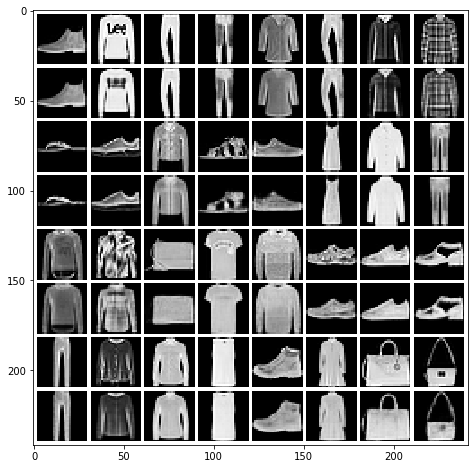

In [71]:
# Print test predictions 2 #

to_plot = np.stack([test_images[:32, 0].reshape(4, 8, 28, 28), 
                    test_outputs[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
                
plot_grid(to_plot, figsize=(8,8), file="../out/e2e/fashion/Ameas{}_6_1024.png".format(m))
#plot_grid(to_plot, figsize=(8,8))

#plot_grid(torch.Tensor(np.stack([test_images[:32, 0].reshape(4, 8, 28, 28), test_outputs[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)),
#          file='/home/shared/phase-retrieval/out/cgan/'+dataset+'/cgan{0}.pdf'.format(time.strftime("%Y%m%d_%H%M%S")))

In [72]:
# Benchmark test predictions #

benchmark(pred=test_outputs[:1024], true=test_images[:1024], check_all=True)

Signal error:
  MSE: 0.004817001521644215, std: 0.00482450791410223
  MAE: 0.032239088389360404, std: 0.017349290331993228
  SSIM: 0.903412523299191, std: 0.0804080405619218
  Sharpness: 0.07057011369689983, std: 0.03785616346315219
  PhCo-MSE: 0.004826273137098269, std: 0.004843079824802548
  PhCo-MAE: 0.03225476673924277, std: 0.017368083967336388
  PhCo-SSIM: 0.9032883742638527, std: 0.08065385748977773
  CroCo-MSE: 0.004817001521644215, std: 0.00482450791410223
  CroCo-MAE: 0.032239088389360404, std: 0.017349290331993228
  CroCo-SSIM: 0.903412523299191, std: 0.0804080405619218

Magnitude error:
  MSE Magnitude: 1.8680503063445413, std: 1.9718257601418059

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.004817 | 0.03224 | 0.9034 | 0.07057 | 0.004826 | 0.03225 | 0.9033 | 0.004817 | 0.03224 | 0.9034 | 1.868 |


## Evaluation for different E2E models (1024 samples)


| Nr Type | epochs | m | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 4 | 100 | 784 | 0.004817 | 0.03224 | 0.9034 | 0.07057 | 0.004826 | 0.03225 | 0.9033 | 0.004817 | 0.03224 | 0.9034 | 1.868 |
| 4 | 100 | 500 | 0.005214 | 0.03355 | 0.8955 | 0.07220 | 0.005215 | 0.03355 | 0.8955 | 0.005214 | 0.03355 | 0.8955 | 2.009 |
| 4 | 100 | 300 | 0.005956 | 0.03597 | 0.8827 | 0.07514 | 0.006017 | 0.03610 | 0.8821 | 0.005955 | 0.03597 | 0.8827 | 2.264 |
| 4 | 100 | 200 | 0.006827 | 0.03854 | 0.8694 | 0.07864 | 0.006862 | 0.03860 | 0.8690 | 0.006825 | 0.03854 | 0.8694 | 2.538 |
| 4 | 100 | 100 | 0.008961 | 0.04416 | 0.8395 | 0.08601 | 0.009271 | 0.04466 | 0.8375 | 0.008952 | 0.04414 | 0.8396 | 3.284 |
| 4 | 100 | 50 | 0.01250 | 0.05289 | 0.7941 | 0.09666 | 0.01349 | 0.05453 | 0.7876 | 0.01241 | 0.05276 | 0.7946 | 4.474 |
| 4 | 100 | 25 | 0.02001 | 0.06857 | 0.7204 | 0.1114 | 0.02346 | 0.07389 | 0.7050 | 0.01938 | 0.06774 | 0.7251 | 7.312 |
| 4 | 100 | 10 | 0.04515 | 0.1118 | 0.5490 | 0.1358 | 0.05401 | 0.1245 | 0.5300 | 0.04034 | 0.1058 | 0.5716 | 17.42 |